# Content of this notebook
1.Inspecting small, emotion-labeled database(686_df)\
2.Create NeuroNetwork model on 686_df\
3.Clean up and labeling big database (Kaggle_df)\
4.Generate a playlist from Kaggle_df

## 1.Loading the small-database

In [120]:
import pandas as pd
import numpy as np

train_df = pd.read_csv('../raw_data/trainset_new.csv')
train_df.head()


,Unnamed: 0.1,Unnamed: 0,track_name,artist,length,danceability,acousticness,energy,instrumentalness,liveness,valence,loudness,speechiness,tempo,key,time_signature,playlist_name,mood
0,0,0,Sequoia (Lovers On The Mountain),Tay Oskee,218216,0.686,0.8730,0.400,0.004540,0.111,0.353,-12.317,0.0357,102.998,8,4,Best of alexrainbirdMusic 2023 🎉,Calm
1,1,1,Warm A Cold Heart,Harrison Storm,221121,0.605,0.6730,0.577,0.427000,0.112,0.389,-11.230,0.1020,83.982,11,4,Best of alexrainbirdMusic 2023 🎉,Calm
2,2,2,Cannonball,Michigander,245946,0.668,0.0267,0.967,0.000043,0.249,0.909,-3.352,0.0360,130.005,6,4,Best of alexrainbirdMusic 2023 🎉,Calm
3,3,3,Free,Ocie Elliott,194908,0.595,0.8040,0.408,0.074500,0.105,0.391,-11.842,0.0298,144.944,2,4,Best of alexrainbirdMusic 2023 🎉,Calm
4,4,4,A Little Closer,Jessie Reid,256522,0.538,0.9560,0.174,0.113000,0.110,0.180,-15.442,0.0306,110.597,1,4,Best of alexrainbirdMusic 2023 🎉,Calm


In [109]:
train_df['mood'].value_counts()

mood
Sad          287
Energetic    265
Calm         261
Happy        260
Name: count, dtype: int64

In [121]:
sad_df = train_df[train_df['mood']=='Sad']
energetic_df = train_df[train_df['mood']=='Energetic']
calm_df = train_df[train_df['mood']=='Calm']
happy_df = train_df[train_df['mood']=='Happy']

In [122]:
train_df_list = []

size_array = np.linspace(0.1,1,20)
size_array

array([0.1       , 0.14736842, 0.19473684, 0.24210526, 0.28947368,
       0.33684211, 0.38421053, 0.43157895, 0.47894737, 0.52631579,
       0.57368421, 0.62105263, 0.66842105, 0.71578947, 0.76315789,
       0.81052632, 0.85789474, 0.90526316, 0.95263158, 1.        ])

In [123]:
for num in size_array:
    sad_df_small = sad_df.sample(int(sad_df.shape[0]*num))
    energetic_df_small = energetic_df.sample(int(energetic_df.shape[0]*num))
    calm_df_small = calm_df.sample(int(calm_df.shape[0]*num))
    happy_df_small = happy_df.sample(int(happy_df.shape[0]*num))

    small_df = pd.concat([sad_df_small,energetic_df_small,calm_df_small,happy_df_small],ignore_index=True)
    train_df_list.append(small_df)

train_df_list


[     Unnamed: 0.1  Unnamed: 0           track_name             artist  length  \
 0             729          55  emails i can’t send  Sabrina Carpenter  104408   
 1             275          18                MAGIC              meija  177000   
 2             719          45              Ribbons        Ryan Beatty  197653   
 3             690          16           Part Of Me        Cian Ducrot  202193   
 4             676           2             Daylight      David Kushner  212954   
 ..            ...         ...                  ...                ...     ...   
 101           155          28             3 Nights       Dominic Fike  177667   
 102           391          40                 Home    Good Neighbours  157486   
 103           429          78      Numb Little Bug         Em Beihold  169238   
 104           131           4              Feather  Sabrina Carpenter  185553   
 105           162          35         Question...?       Taylor Swift  210557   
 
      danceabi

## 2.Train NeuroNetwork on train_df

In [100]:
#Target encoding
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import RobustScaler

loss_array = []
loss_array_val = []
accuracy_array = []
accuracy_array_val = []
result_test_array = []
result_train_array = []

for df in train_df_list:
    oh_encoder = OneHotEncoder(sparse_output=False)
    oh_encoder.fit(df[['mood']])
    df[oh_encoder.get_feature_names_out()] = oh_encoder.transform(df[['mood']])
    df.drop(columns=['mood'],inplace=True)

    #Split the dataframe
    y = df[['mood_Calm', 'mood_Energetic', 'mood_Happy', 'mood_Sad']]
    X = df[['length', 'danceability',
       'acousticness', 'energy', 'instrumentalness', 'liveness', 'valence',
       'loudness', 'speechiness', 'tempo', 'key', 'time_signature']]

    #Train test split
    from sklearn.model_selection import train_test_split
    X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=42)

    scaler = RobustScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    from tensorflow import keras

    model = keras.models.Sequential()
    model.add(keras.layers.Dense(30,activation='relu',input_dim=12))
    model.add(keras.layers.Dropout(rate=0.3))

    model.add(keras.layers.Dense(10,activation='relu'))
    model.add(keras.layers.Dropout(rate=0.2))

    model.add(keras.layers.Dense(4,activation='softmax'))

    model.compile(optimizer='adam',
            loss='categorical_crossentropy',
            metrics=['accuracy'])
    es = keras.callbacks.EarlyStopping(patience=20)

    history = model.fit(X_train_scaled,y_train,
                    validation_split=0.3,
                    batch_size=16,
                    epochs=300,
                    callbacks=[es])

    result_test_array.append(model.evaluate(X_test_scaled,y_test))
    result_train_array.append(model.evaluate(X_train_scaled,y_train))

    loss_array.append(history.history['loss'])
    loss_array_val.append(history.history['val_loss'])

    accuracy_array.append(history.history['accuracy'])
    accuracy_array_val.append(history.history['val_accuracy'])

Epoch 1/300
4/4 [==============================] - 2s 132ms/step - loss: 21.6236 - accuracy: 0.2157 - val_loss: 3.2467 - val_accuracy: 0.2174
Epoch 2/300
4/4 [==============================] - 0s 23ms/step - loss: 42.8501 - accuracy: 0.2549 - val_loss: 3.0351 - val_accuracy: 0.1739
Epoch 3/300
4/4 [==============================] - 0s 24ms/step - loss: 29.3738 - accuracy: 0.2157 - val_loss: 2.7863 - val_accuracy: 0.1304
Epoch 4/300
4/4 [==============================] - 0s 24ms/step - loss: 24.6787 - accuracy: 0.1765 - val_loss: 2.5588 - val_accuracy: 0.1304
Epoch 5/300
4/4 [==============================] - 0s 26ms/step - loss: 31.6313 - accuracy: 0.2549 - val_loss: 2.3950 - val_accuracy: 0.1304
Epoch 6/300
4/4 [==============================] - 0s 23ms/step - loss: 21.5986 - accuracy: 0.1961 - val_loss: 2.3600 - val_accuracy: 0.1304
Epoch 7/300
4/4 [==============================] - 0s 21ms/step - loss: 5.9642 - accuracy: 0.1765 - val_loss: 2.3891 - val_accuracy: 0.0870
Epoch 8/300
4

In [101]:
result_loss_test = [value[0] for value in result_test_array]
result_loss_train = [value[0] for value in result_train_array]

result_accuracy_test = [value[1] for value in result_test_array]
result_accuracy_train = [value[1] for value in result_train_array]

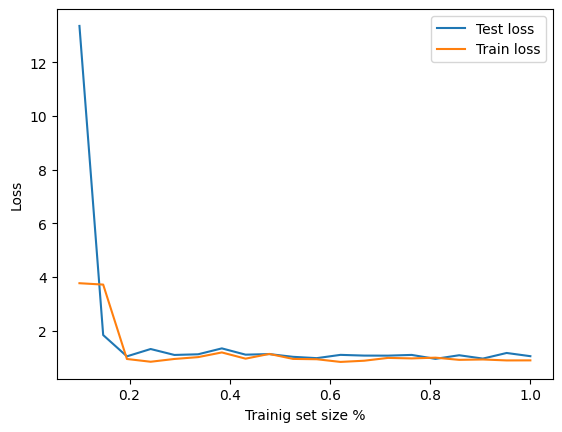

In [102]:
#Display learning curve
import matplotlib.pyplot as plt
plt.plot(size_array,result_loss_test,label='Test loss')
plt.plot(size_array,result_loss_train,label='Train loss')
plt.ylabel('Loss')
plt.xlabel('Trainig set size %')
plt.legend()
plt.show()

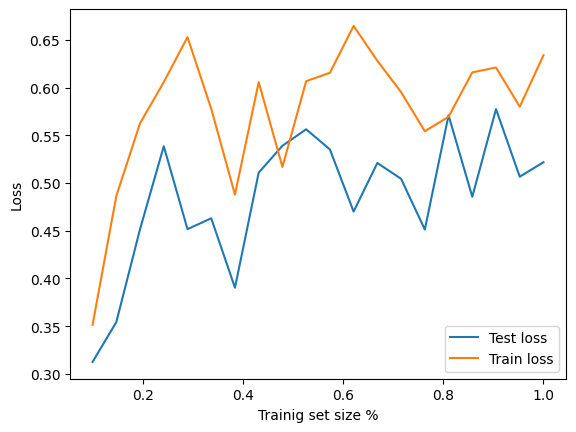

In [103]:
plt.plot(size_array,result_accuracy_test,label='Test loss')
plt.plot(size_array,result_accuracy_train,label='Train loss')
plt.ylabel('Loss')
plt.xlabel('Trainig set size %')
plt.legend()
plt.show()

In [71]:
loss_output = [value[-1] for value in loss_array]
accuracy_output = [value[-1] for value in accuracy_array]

In [72]:
loss_output_val = [value[-1] for value in loss_array_val]
accuracy_output_val = [value[-1] for value in accuracy_array_val]

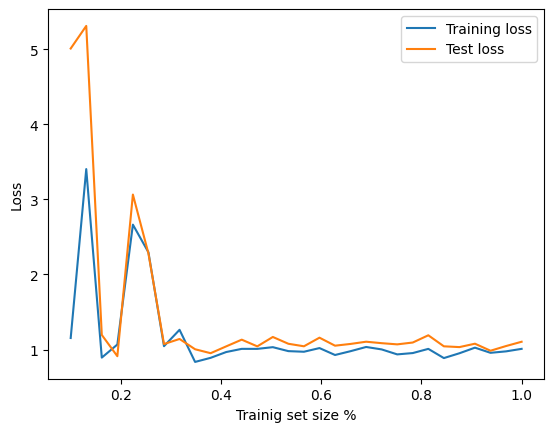

In [73]:
#Display learning curve
import matplotlib.pyplot as plt
plt.plot(size_array,loss_output,label='Training loss')
plt.plot(size_array,loss_output_val,label='Test loss')
plt.ylabel('Loss')
plt.xlabel('Trainig set size %')
plt.legend()
plt.show()

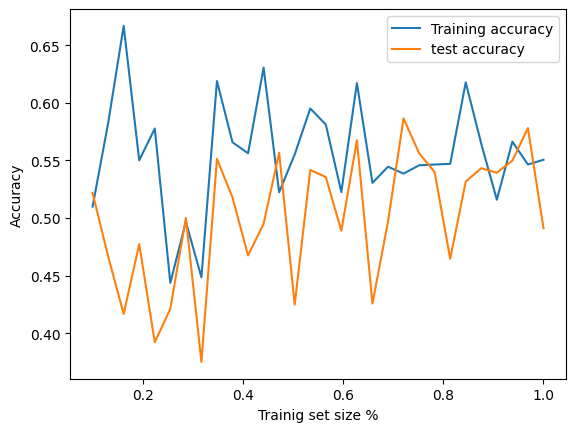

In [74]:
plt.plot(size_array,accuracy_output,label='Training accuracy')
plt.plot(size_array,accuracy_output_val,label='test accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Trainig set size %')
plt.legend()
plt.show()

# -----

In [124]:
#Change metrics to F1 score
import tensorflow_addons as tfa

f1 = tfa.metrics.F1Score(36,'micro')

loss_array = []
loss_array_val = []
f1_array = []
f1_array_val = []
result_test_array = []
result_train_array = []

for df in train_df_list:
    oh_encoder = OneHotEncoder(sparse_output=False)
    oh_encoder.fit(df[['mood']])
    df[oh_encoder.get_feature_names_out()] = oh_encoder.transform(df[['mood']])
    df.drop(columns=['mood'],inplace=True)

    #Split the dataframe
    y = df[['mood_Calm', 'mood_Energetic', 'mood_Happy', 'mood_Sad']]
    X = df[['length', 'danceability',
       'acousticness', 'energy', 'instrumentalness', 'liveness', 'valence',
       'loudness', 'speechiness', 'tempo', 'key', 'time_signature']]

    #Train test split
    from sklearn.model_selection import train_test_split
    X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=42)

    scaler = RobustScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    from tensorflow import keras

    model = keras.models.Sequential()
    model.add(keras.layers.Dense(30,activation='relu',input_dim=12))
    model.add(keras.layers.Dropout(rate=0.3))

    model.add(keras.layers.Dense(10,activation='relu'))
    model.add(keras.layers.Dropout(rate=0.2))

    model.add(keras.layers.Dense(4,activation='softmax'))

    model.compile(optimizer='adam',
            loss='categorical_crossentropy',
            metrics=[f1])
    es = keras.callbacks.EarlyStopping(patience=20)

    history = model.fit(X_train_scaled,y_train,
                    validation_split=0.3,
                    batch_size=16,
                    epochs=300,
                    callbacks=[es])

    result_test_array.append(model.evaluate(X_test_scaled,y_test))
    result_train_array.append(model.evaluate(X_train_scaled,y_train))

    loss_array.append(history.history['loss'])
    loss_array_val.append(history.history['val_loss'])

    accuracy_array.append(history.history['f1_score'])
    accuracy_array_val.append(history.history['val_f1_score'])

Epoch 1/300
4/4 [==============================] - 3s 166ms/step - loss: 3.2574 - f1_score: 0.1569 - val_loss: 1.4542 - val_f1_score: 0.1304
Epoch 2/300
4/4 [==============================] - 0s 45ms/step - loss: 5.8251 - f1_score: 0.2941 - val_loss: 1.4378 - val_f1_score: 0.0870
Epoch 3/300
4/4 [==============================] - 0s 29ms/step - loss: 4.6006 - f1_score: 0.1569 - val_loss: 1.4245 - val_f1_score: 0.0870
Epoch 4/300
4/4 [==============================] - 0s 28ms/step - loss: 2.9520 - f1_score: 0.2157 - val_loss: 1.4154 - val_f1_score: 0.0870
Epoch 5/300
4/4 [==============================] - 0s 28ms/step - loss: 2.8209 - f1_score: 0.3137 - val_loss: 1.4118 - val_f1_score: 0.1304
Epoch 6/300
4/4 [==============================] - 0s 27ms/step - loss: 3.3722 - f1_score: 0.1961 - val_loss: 1.4134 - val_f1_score: 0.1304
Epoch 7/300
4/4 [==============================] - 0s 33ms/step - loss: 5.0940 - f1_score: 0.2353 - val_loss: 1.4191 - val_f1_score: 0.1304
Epoch 8/300
4/4 [==

In [125]:
result_loss_test = [value[0] for value in result_test_array]
result_loss_train = [value[0] for value in result_train_array]

result_f1_test = [value[1] for value in result_test_array]
result_f1_train = [value[1] for value in result_train_array]

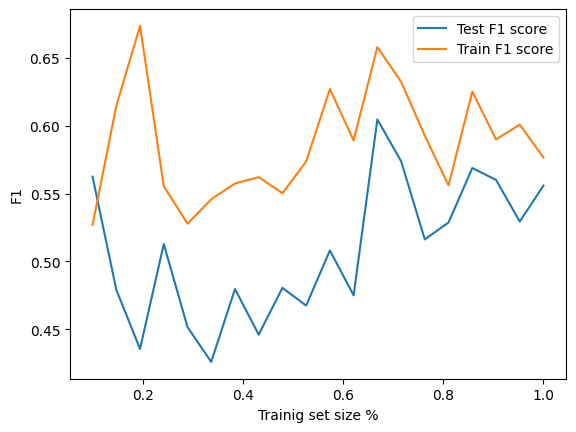

In [126]:
plt.plot(size_array,result_f1_test,label='Test F1 score')
plt.plot(size_array,result_f1_train,label='Train F1 score')
plt.ylabel('F1')
plt.xlabel('Trainig set size %')
plt.legend()
plt.show()

# -----

In [110]:
#One Hot Encode the train_df
ohe = OneHotEncoder(sparse_output=False)
ohe.fit(train_df[['mood']])
train_df[ohe.get_feature_names_out()] = ohe.transform(train_df[['mood']])
train_df.drop(columns=['mood'],inplace=True)

#Split the dataframe
y = train_df[['mood_Calm', 'mood_Energetic', 'mood_Happy', 'mood_Sad']]
X = train_df[['length', 'danceability',
       'acousticness', 'energy', 'instrumentalness', 'liveness', 'valence',
       'loudness', 'speechiness', 'tempo', 'key', 'time_signature']]

#Train test split
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=42)

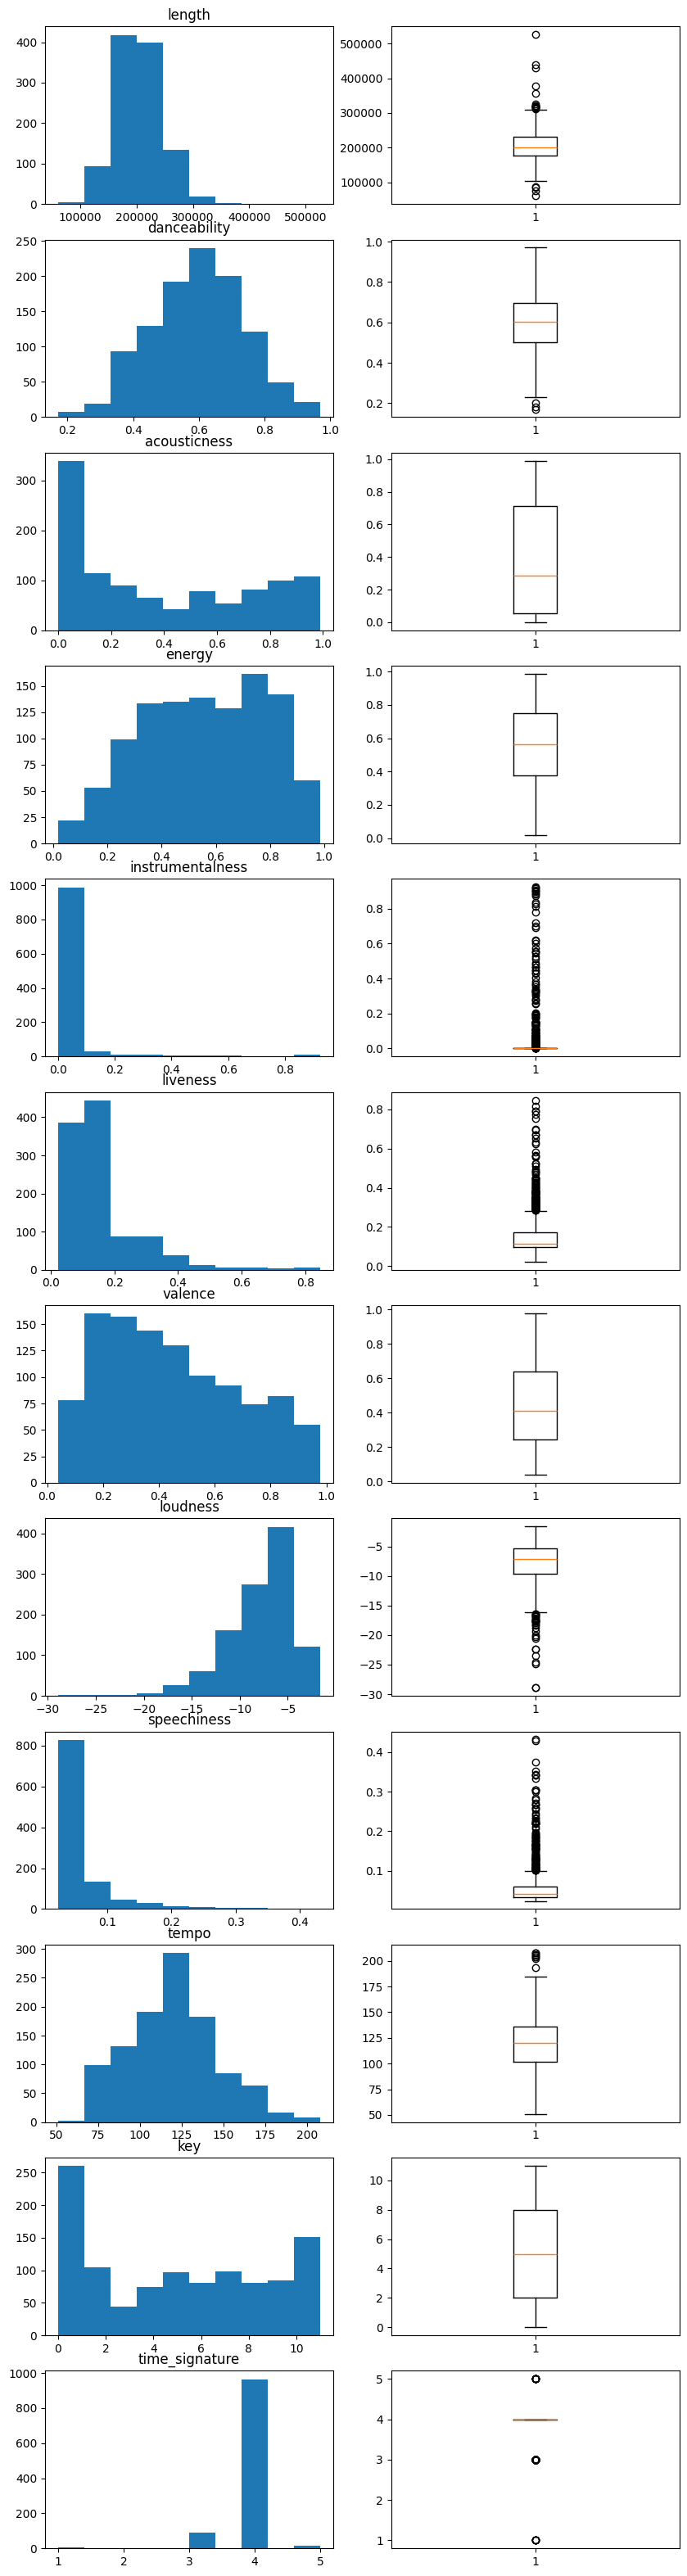

In [111]:
#Check the histogram of each features
import matplotlib.pyplot as plt

fig, axs = plt.subplots(12, 2, figsize=(10,40))

for i in range(12):
    axs[i,0].hist(X[X.keys().to_list()[i]])
    axs[i,1].boxplot(X[X.keys().to_list()[i]])
    axs[i,0].set_title(f'{X.keys().to_list()[i]}')
plt.show()

In [7]:
# #Standard scaling
# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train)
# X_test_scaled = scaler.transform(X_test)

In [112]:
#Robust scaling
from sklearn.preprocessing import RobustScaler
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [116]:
#Deep Learning
from tensorflow import keras
import tensorflow_addons as tfa

f1 = tfa.metrics.F1Score(36,'micro')

# Custom F1 score metric function
model = keras.models.Sequential()
model.add(keras.layers.Dense(30,activation='relu',input_dim=12))
model.add(keras.layers.Dropout(rate=0.3))

model.add(keras.layers.Dense(10,activation='relu'))
model.add(keras.layers.Dropout(rate=0.2))

model.add(keras.layers.Dense(4,activation='softmax'))

model.compile(optimizer='adam',
            loss='categorical_crossentropy',
            metrics=[f1])

model.summary()

Model: "sequential_65"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_195 (Dense)           (None, 30)                390       
                                                                 
 dropout_130 (Dropout)       (None, 30)                0         
                                                                 
 dense_196 (Dense)           (None, 10)                310       
                                                                 
 dropout_131 (Dropout)       (None, 10)                0         
                                                                 
 dense_197 (Dense)           (None, 4)                 44        
                                                                 
Total params: 744 (2.91 KB)
Trainable params: 744 (2.91 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [117]:
es = keras.callbacks.EarlyStopping(patience=20)

history = model.fit(X_train_scaled,y_train,
                    validation_split=0.3,
                    batch_size=8,
                    epochs=300,
                    callbacks=[es])

Epoch 1/300
66/66 [==============================] - 3s 11ms/step - loss: 4.2537 - f1_score: 0.3086 - val_loss: 2.3328 - val_f1_score: 0.3363
Epoch 2/300
66/66 [==============================] - 0s 6ms/step - loss: 3.1149 - f1_score: 0.3181 - val_loss: 1.6976 - val_f1_score: 0.3584
Epoch 3/300
66/66 [==============================] - 0s 6ms/step - loss: 2.2900 - f1_score: 0.3314 - val_loss: 1.3058 - val_f1_score: 0.3628
Epoch 4/300
66/66 [==============================] - 0s 6ms/step - loss: 2.0517 - f1_score: 0.3524 - val_loss: 1.2380 - val_f1_score: 0.3805
Epoch 5/300
66/66 [==============================] - 0s 6ms/step - loss: 2.2486 - f1_score: 0.3448 - val_loss: 1.2206 - val_f1_score: 0.3673
Epoch 6/300
66/66 [==============================] - 0s 6ms/step - loss: 1.7711 - f1_score: 0.3905 - val_loss: 1.2046 - val_f1_score: 0.4027
Epoch 7/300
66/66 [==============================] - 0s 6ms/step - loss: 1.5521 - f1_score: 0.3848 - val_loss: 1.1897 - val_f1_score: 0.4115
Epoch 8/300


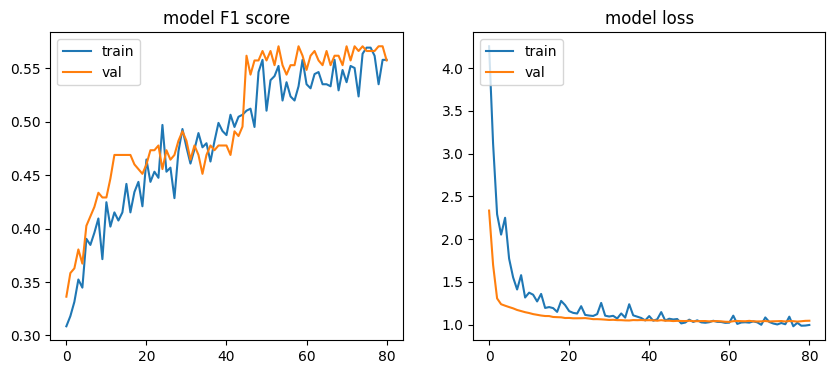

In [119]:
#Plot the history
fig, axs = plt.subplots(1, 2, figsize=(10,4))
axs[0].plot(history.history['f1_score'])
axs[0].plot(history.history['val_f1_score'])
axs[0].set_title('model F1 score')
axs[0].legend(['train', 'val'], loc='upper left')

axs[1].plot(history.history['loss'])
axs[1].plot(history.history['val_loss'])
axs[1].set_title('model loss')
axs[1].legend(['train', 'val'], loc='upper left')

plt.show()

In [86]:
result = model.evaluate(X_test_scaled,y_test)
result

11/11 [==============================] - 0s 4ms/step - loss: 0.9670 - accuracy: 0.5248


[0.9670432806015015, 0.5248447060585022]

The model unable to surpass 60% accuracy with handmade trainset.

## 3.Clean up and Scale Kaggle_df, and label it using our model

### Clean up Kaggle_df

In [12]:
kaggle_df = pd.read_csv('../raw_data/spotify_dataset.csv')
kaggle_df = kaggle_df.rename(columns={'track_id':'id','artists':'artist','album_name':'album',
                          'track_name':'name','duration_ms':'length'})

#Drop unnecessary columns (These columns are not included in 686_df)
kaggle_df = kaggle_df.drop(columns={'explicit','mode','Unnamed: 0'})

#Reorder the columns in kaggle database to match 686_df columns
kaggle_df = kaggle_df[df_686.columns.to_list()[:-4]+['track_genre']]

#Drop duplicated rows from kaggle_df
kaggle_df = kaggle_df.drop_duplicates(subset='name')
kaggle_df.head()

,name,album,artist,id,popularity,length,danceability,acousticness,energy,instrumentalness,liveness,valence,loudness,speechiness,tempo,key,time_signature,track_genre
0,Comedy,Comedy,Gen Hoshino,5SuOikwiRyPMVoIQDJUgSV,73,230666,0.676,0.0322,0.4610,0.000001,0.3580,0.715,-6.746,0.1430,87.917,1,4,acoustic
1,Ghost - Acoustic,Ghost (Acoustic),Ben Woodward,4qPNDBW1i3p13qLCt0Ki3A,55,149610,0.420,0.9240,0.1660,0.000006,0.1010,0.267,-17.235,0.0763,77.489,1,4,acoustic
2,To Begin Again,To Begin Again,Ingrid Michaelson;ZAYN,1iJBSr7s7jYXzM8EGcbK5b,57,210826,0.438,0.2100,0.3590,0.000000,0.1170,0.120,-9.734,0.0557,76.332,0,4,acoustic
3,Can't Help Falling In Love,Crazy Rich Asians (Original Motion Picture Sou...,Kina Grannis,6lfxq3CG4xtTiEg7opyCyx,71,201933,0.266,0.9050,0.0596,0.000071,0.1320,0.143,-18.515,0.0363,181.740,0,3,acoustic
4,Hold On,Hold On,Chord Overstreet,5vjLSffimiIP26QG5WcN2K,82,198853,0.618,0.4690,0.4430,0.000000,0.0829,0.167,-9.681,0.0526,119.949,2,4,acoustic


### Drop songs that don't match our goal

In [13]:
#Speechness selection: drop radioshows, liveshows and back ground musics
kaggle_df = kaggle_df[(kaggle_df['speechiness']>0.33) & (kaggle_df['speechiness']<0.50)]
kaggle_df = kaggle_df[kaggle_df['liveness']<0.8]

#Instrumentalness selection: drop bgms.
kaggle_df = kaggle_df[kaggle_df['instrumentalness']<0.9]

### Scale Kaggle_df

In [14]:
kaggle_df_scaled = scaler.transform(kaggle_df[['length', 'danceability',
       'acousticness', 'energy', 'instrumentalness', 'liveness', 'valence',
       'loudness', 'speechiness', 'tempo', 'key', 'time_signature']])

### Label with mood using our model

In [15]:
kaggle_mood = model.predict(kaggle_df_scaled)
kaggle_df[['mood_Calm', 'mood_Energetic', 'mood_Happy', 'mood_Sad']] = kaggle_mood
kaggle_df.head(5)

54/54 [==============================] - 1s 5ms/step


,name,album,artist,id,popularity,length,danceability,acousticness,energy,instrumentalness,...,loudness,speechiness,tempo,key,time_signature,track_genre,mood_Calm,mood_Energetic,mood_Happy,mood_Sad
768,Memories (Acoustic),Memories (Acoustic),Ben Woodward,1m3Lsbhkn6yL8apzsCiukd,46,183337,0.802,0.809,0.183,0.0,...,-17.100,0.403,91.078,8,4,acoustic,0.000287,0.003602,0.078374,0.917737
1001,Ainda Há Tempo,Ainda Há Tempo,Criolo,4Ds4bq6aqOSAp1T7DikOi4,44,318360,0.580,0.281,0.800,0.0,...,-7.528,0.345,81.303,6,4,afrobeat,0.000438,0.205746,0.394569,0.399247
1012,Breaco,Ainda Há Tempo,Criolo,0J4hFHpfCAlJOdrtcm04vz,40,177240,0.619,0.148,0.781,0.0,...,-6.548,0.333,182.026,1,4,afrobeat,0.000007,0.429782,0.534752,0.035460
1014,É o Teste,Ainda Há Tempo,Criolo,7cAxwshLN1yidrBlDePrYW,41,279720,0.660,0.178,0.728,0.0,...,-6.177,0.337,91.101,10,4,afrobeat,0.000144,0.239061,0.489263,0.271532
1091,Grajauex - Live,Criolo E Emicida Ao Vivo (Live),Criolo;Emicida,0UZ3juSCFsN6lINBadUZNZ,33,191453,0.358,0.304,0.905,0.0,...,-5.776,0.453,176.670,5,4,afrobeat,0.000039,0.799761,0.151770,0.048430


In [16]:
#Make a simpler dataframe
kaggle_df_simple = kaggle_df[['name', 'album', 'artist', 'id', 'popularity', 'track_genre',
       'mood_Calm', 'mood_Energetic', 'mood_Happy', 'mood_Sad']]
kaggle_df_simple.head()

,name,album,artist,id,popularity,track_genre,mood_Calm,mood_Energetic,mood_Happy,mood_Sad
768,Memories (Acoustic),Memories (Acoustic),Ben Woodward,1m3Lsbhkn6yL8apzsCiukd,46,acoustic,0.000287,0.003602,0.078374,0.917737
1001,Ainda Há Tempo,Ainda Há Tempo,Criolo,4Ds4bq6aqOSAp1T7DikOi4,44,afrobeat,0.000438,0.205746,0.394569,0.399247
1012,Breaco,Ainda Há Tempo,Criolo,0J4hFHpfCAlJOdrtcm04vz,40,afrobeat,0.000007,0.429782,0.534752,0.035460
1014,É o Teste,Ainda Há Tempo,Criolo,7cAxwshLN1yidrBlDePrYW,41,afrobeat,0.000144,0.239061,0.489263,0.271532
1091,Grajauex - Live,Criolo E Emicida Ao Vivo (Live),Criolo;Emicida,0UZ3juSCFsN6lINBadUZNZ,33,afrobeat,0.000039,0.799761,0.151770,0.048430


All the genres in kaggle_df:\
 'acoustic', 'afrobeat', 'alt-rock', 'alternative', 'ambient',
       'anime', 'black-metal', 'bluegrass', 'blues', 'brazil',
       'breakbeat', 'british', 'cantopop', 'chicago-house', 'children',
       'chill', 'classical', 'club', 'comedy', 'country', 'dance',
       'dancehall', 'death-metal', 'deep-house', 'detroit-techno',
       'disco', 'disney', 'drum-and-bass', 'dub', 'dubstep', 'edm',
       'electro', 'electronic', 'emo', 'folk', 'forro', 'french', 'funk',
       'garage', 'german', 'gospel', 'goth', 'grindcore', 'groove',
       'grunge', 'guitar', 'happy', 'hard-rock', 'hardcore', 'hardstyle',
       'heavy-metal', 'hip-hop', 'honky-tonk', 'house', 'idm', 'indian',
       'indie-pop', 'indie', 'industrial', 'iranian', 'j-dance', 'j-idol',
       'j-pop', 'j-rock', 'jazz', 'k-pop', 'kids', 'latin', 'latino',
       'malay', 'mandopop', 'metal', 'metalcore', 'minimal-techno', 'mpb',
       'new-age', 'opera', 'pagode', 'party', 'piano', 'pop-film', 'pop',
       'power-pop', 'progressive-house', 'psych-rock', 'punk-rock',
       'punk', 'r-n-b', 'reggae', 'reggaeton', 'rock-n-roll', 'rock',
       'rockabilly', 'romance', 'sad', 'salsa', 'samba', 'sertanejo',
       'show-tunes', 'singer-songwriter', 'ska', 'sleep', 'soul',
       'spanish', 'study', 'swedish', 'synth-pop', 'tango', 'techno',
       'trance', 'trip-hop', 'turkish', 'world-music'

In [17]:
#Just for experiment, exclude several genres:
genres_to_exclude = {'grunge', 'guitar','gospel','anime','children','brazil','german','kids','malay','opera','mandopop','iranian','comedy','cantopop'
    'pagode','piano','salsa','samba','sertanejo','sleep','tango','turkish', 'world-music','folk','classical','indian','study','forro','j-idol','pop-film'}

kaggle_df_simple = kaggle_df_simple[~kaggle_df_simple['track_genre'].isin(genres_to_exclude)]

## 4.Generate Playlist function

In [22]:
import spotipy
from spotipy.oauth2 import SpotifyOAuth
import os

########VARIABLES######
SPOTIFY_CLIENT_ID = os.environ.get("SPOTIFY_CLIENT_ID")
SPOTIFY_SECRET = os.environ.get("SPOTIFY_SECRET")
SPOTIFY_USERNAME = os.environ.get("SPOTIFY_USERNAME")
REDIRECT_URI = os.environ.get("REDIRECT_URI")

def generate_playlist(df,emotion):
    '''This function will access Spotify API and add playlist to your account.
    The songs will be chosen from the provided df.'''

    sp = spotipy.Spotify(
        auth_manager=SpotifyOAuth(
            scope="playlist-modify-public",
            redirect_uri=REDIRECT_URI,
            client_id=SPOTIFY_CLIENT_ID,
            client_secret=SPOTIFY_SECRET,
            show_dialog=True,
            cache_path="token.txt",
            username=SPOTIFY_USERNAME,
        )
    )

    user_id = sp.current_user()["id"]

    new_playlist = sp.user_playlist_create(user=user_id, name=f"{emotion} playlist for you!", public=True,
                                      description=None)
    new_playlist_id = new_playlist["id"]

    # Select some music from df.

    title_list_sample = list(df.head(10)['name'])



    uri_list = []
    for value in range(10):
        spotify_result = sp.search(q=f"track:{title_list_sample[value]}",type="track", market="US")
        try:
            result_uri = spotify_result["tracks"]["items"][0]["uri"]
        except IndexError:
            pass
        else:
            uri_list.append(result_uri)

    sp.user_playlist_add_tracks(user=user_id, playlist_id=new_playlist_id, tracks=uri_list)

In [ ]:
#This function is added later;
#Taking into account that the mixture of four emotions is passed from facial recognition module.
# emotion = {'Happy':0.4,'Sad':0.2,''}

# def tailor_df_new(emotion):


In [23]:
def tailor_df(emotion:str):
    '''This function takes emotion input from facial recognition
    and outputs a dataframe tailored for that emotion'''
    if emotion == 'anger' or 'disgust' or 'fear':
        mood_df = kaggle_df_simple.sort_values('mood_Calm',ascending=False).head(200)
        mood_df = mood_df.sort_values('mood_Energetic',ascending=True).head(100).sample(10)

    elif emotion == 'enthusiasm':
        mood_df = kaggle_df_simple.sort_values('mood_Energetic',ascending=False).head(200)
        mood_df = mood_df.sort_values('mood_Calm',ascending=True).head(100).sample(10)

    elif emotion == 'happiness' or 'neutral':
        mood_df = kaggle_df_simple.sort_values('mood_Happy',ascending=False).head(200)
        mood_df = mood_df.sort_values('mood_Sad',ascending=True).head(100).sample(10)

    else:
        mood_df = kaggle_df_simple.sort_values('mood_Sad',ascending=False).head(200)
        mood_df = mood_df.sort_values('mood_Happy',ascending=True).head(100).sample(10)

    return mood_df

In [20]:
#Generate playlist.
current_emotion = 'Energetic'

generate_playlist(df=tailor_df(current_emotion),emotion=current_emotion)


## Explore other dataset: top 10000 tracks on Spotify since 1960.

In [136]:
import pandas as pd
new_df = pd.read_csv('../raw_data/top_10000_1960-now.csv')

In [137]:
#Clean up dataframe
new_df = new_df.drop(columns={'Artist URI(s)','Album URI', 'Album Artist URI(s)','Album Artist Name(s)',
                      'Album Image URL','Disc Number', 'Track Number',
                      'Track Preview URL', 'Explicit', 'ISRC', 'Added By','Added At',
                      'Album Genres','Label', 'Copyrights','Mode'})
new_df = new_df.drop_duplicates()
new_df = new_df[new_df['Danceability'].isna()==False]
new_df = new_df[new_df['Track Name'].isna()==False]

In [138]:
new_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9948 entries, 0 to 9998
Data columns (total 19 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Track URI            9948 non-null   object 
 1   Track Name           9948 non-null   object 
 2   Artist Name(s)       9948 non-null   object 
 3   Album Name           9948 non-null   object 
 4   Album Release Date   9948 non-null   object 
 5   Track Duration (ms)  9948 non-null   int64  
 6   Popularity           9948 non-null   int64  
 7   Artist Genres        9402 non-null   object 
 8   Danceability         9948 non-null   float64
 9   Energy               9948 non-null   float64
 10  Key                  9948 non-null   float64
 11  Loudness             9948 non-null   float64
 12  Speechiness          9948 non-null   float64
 13  Acousticness         9948 non-null   float64
 14  Instrumentalness     9948 non-null   float64
 15  Liveness             9948 non-null   float6

In [139]:
df_686 = pd.read_csv('../raw_data/mood+music686.csv')
df_686.keys()

Index(['name', 'album', 'artist', 'id', 'release_date', 'popularity', 'length',
       'danceability', 'acousticness', 'energy', 'instrumentalness',
       'liveness', 'valence', 'loudness', 'speechiness', 'tempo', 'key',
       'time_signature', 'mood'],
      dtype='object')

In [28]:
df_686.head()

,name,album,artist,id,release_date,popularity,length,danceability,acousticness,energy,instrumentalness,liveness,valence,loudness,speechiness,tempo,key,time_signature,mood
0,1999,1999,Prince,2H7PHVdQ3mXqEHXcvclTB0,1982-10-27,68,379266,0.866,0.13700,0.730,0.000000,0.0843,0.625,-8.201,0.0767,118.523,5,4,Happy
1,23,23,Blonde Redhead,4HIwL9ii9CcXpTOTzMq0MP,2007-04-16,43,318800,0.381,0.01890,0.832,0.196000,0.1530,0.166,-5.069,0.0492,120.255,8,4,Sad
2,9 Crimes,9,Damien Rice,5GZEeowhvSieFDiR8fQ2im,2006-11-06,60,217946,0.346,0.91300,0.139,0.000077,0.0934,0.116,-15.326,0.0321,136.168,0,4,Sad
3,99 Luftballons,99 Luftballons,Nena,6HA97v4wEGQ5TUClRM0XLc,1984-08-21,2,233000,0.466,0.08900,0.438,0.000006,0.1130,0.587,-12.858,0.0608,193.100,4,4,Happy
4,A Boy Brushed Red Living In Black And White,They're Only Chasing Safety,Underoath,47IWLfIKOKhFnz1FUEUIkE,2004-01-01,60,268000,0.419,0.00171,0.932,0.000000,0.1370,0.445,-3.604,0.1060,169.881,1,4,Energetic


In [140]:
new_df = new_df.rename(columns={'Track Name':'name','Album Name':'album','Artist Name(s)':'artist','Track URI':'id','Album Release Date':'release_date'
                                ,'Popularity':'popularity','Track Duration (ms)':'length','Danceability':'danceability','Acousticness':'acousticness',
                                'Energy':'energy','Instrumentalness':'instrumentalness','Liveness':'liveness','Valence':'valence',
    'Tempo':'tempo','Key':'key','Time Signature':'time_signature','Loudness':'loudness','Speechiness':'speechiness','Artist Genres':'track_genre'})
new_df.head()

,id,name,artist,album,release_date,length,popularity,track_genre,danceability,energy,key,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature
0,spotify:track:1XAZlnVtthcDZt2NI1Dtxo,Justified & Ancient - Stand by the Jams,The KLF,Songs Collection,1992-08-03,216270,0,"acid house,ambient house,big beat,hip house",0.617,0.872,8.0,-12.305,0.0480,0.0158,0.112000,0.4080,0.504,111.458,4.0
1,spotify:track:6a8GbQIlV8HBUW3c6Uk9PH,I Know You Want Me (Calle Ocho),Pitbull,Pitbull Starring In Rebelution,2009-10-23,237120,64,"dance pop,miami hip hop,pop",0.825,0.743,2.0,-5.995,0.1490,0.0142,0.000021,0.2370,0.800,127.045,4.0
2,spotify:track:70XtWbcVZcpaOddJftMcVi,From the Bottom of My Broken Heart,Britney Spears,...Baby One More Time (Digital Deluxe Version),1999-01-12,312533,56,"dance pop,pop",0.677,0.665,7.0,-5.171,0.0305,0.5600,0.000001,0.3380,0.706,74.981,4.0
3,spotify:track:1NXUWyPJk5kO6DQJ5t7bDu,Apeman - 2014 Remastered Version,The Kinks,"Lola vs. Powerman and the Moneygoround, Pt. On...",2014-10-20,233400,42,"album rock,art rock,british invasion,classic r...",0.683,0.728,9.0,-8.920,0.2590,0.5680,0.000051,0.0384,0.833,75.311,4.0
4,spotify:track:72WZtWs6V7uu3aMgMmEkYe,You Can't Always Get What You Want,The Rolling Stones,Let It Bleed,1969-12-05,448720,0,"album rock,british invasion,classic rock,rock",0.319,0.627,0.0,-9.611,0.0687,0.6750,0.000073,0.2890,0.497,85.818,4.0


In [141]:
new_df.shape

#The difference in columns: df_686 has 'mood', new_df has 'Artist Genres'

(9948, 19)

In [142]:
#Drop unnecessary features
new_df = new_df[new_df['length']<400000]
new_df = new_df[new_df['liveness']<0.3]
new_df = new_df[new_df['loudness']>-30]
#new_df = new_df[new_df['speechiness']>0.1]

In [143]:
#Scale the dataframe
new_df_scaled = scaler.transform(new_df[['length', 'danceability',
    'acousticness', 'energy', 'instrumentalness', 'liveness', 'valence',
    'loudness', 'speechiness', 'tempo', 'key', 'time_signature']])

new_df_mood = model.predict(new_df_scaled)
new_df[['mood_Calm', 'mood_Energetic', 'mood_Happy', 'mood_Sad']] = new_df_mood

print(new_df.shape)

33/33 [==============================] - 0s 4ms/step
(1040, 23)


In [144]:
new_df.head()

,id,name,artist,album,release_date,length,popularity,track_genre,danceability,energy,...,acousticness,instrumentalness,liveness,valence,tempo,time_signature,mood_Calm,mood_Energetic,mood_Happy,mood_Sad
1,spotify:track:6a8GbQIlV8HBUW3c6Uk9PH,I Know You Want Me (Calle Ocho),Pitbull,Pitbull Starring In Rebelution,2009-10-23,237120,64,"dance pop,miami hip hop,pop",0.825,0.743,...,0.0142,0.000021,0.2370,0.800,127.045,4.0,0.079434,0.258986,0.208040,0.453541
3,spotify:track:1NXUWyPJk5kO6DQJ5t7bDu,Apeman - 2014 Remastered Version,The Kinks,"Lola vs. Powerman and the Moneygoround, Pt. On...",2014-10-20,233400,42,"album rock,art rock,british invasion,classic r...",0.683,0.728,...,0.5680,0.000051,0.0384,0.833,75.311,4.0,0.012874,0.129736,0.058940,0.798450
6,spotify:track:0d2iYfpKoM0QCKvcLCkBao,Eastside (with Halsey & Khalid),"benny blanco, Halsey, Khalid",Eastside (with Halsey & Khalid),2018-07-12,173799,78,"pop,electropop,etherpop,indie poptimism,pop,po...",0.560,0.680,...,0.5550,0.000000,0.1160,0.319,89.391,4.0,0.009323,0.115997,0.046771,0.827909
17,spotify:track:5yJCo7EewUcX9qj5nnk9O2,Baby Sittin' Boogie - Radio Version,Buzz Clifford,Rock & Roll 50s & 60s Mix,2016-10-01,122958,6,NaN,0.483,0.533,...,0.8050,0.000000,0.1610,0.878,140.110,4.0,0.040219,0.172374,0.119111,0.668297
38,spotify:track:4pbJqGIASGPr0ZpGpnWkDn,We Will Rock You - Remastered 2011,Queen,News Of The World (2011 Remaster),1977-10-28,122066,82,"classic rock,glam rock,rock",0.692,0.497,...,0.6760,0.000000,0.2590,0.475,81.308,4.0,0.148268,0.211329,0.202504,0.437899


In [42]:
# def tailor_df(emotion:str):
#     '''This function takes emotion input from facial recognition
#     and outputs a dataframe tailored for that emotion'''
#     if emotion == 'anger' or 'disgust' or 'fear':
#         mood_df = new_df.sort_values('mood_Calm',ascending=False).head(200)
#         mood_df = mood_df.sort_values('mood_Energetic',ascending=True).head(100).sample(10)

#     elif emotion == 'enthusiasm':
#         mood_df = new_df.sort_values('mood_Energetic',ascending=False).head(200)
#         mood_df = mood_df.sort_values('mood_Calm',ascending=True).head(100).sample(10)

#     elif emotion == 'happiness' or 'neutral':
#         mood_df = new_df.sort_values('mood_Happy',ascending=False).head(200)
#         mood_df = mood_df.sort_values('mood_Sad',ascending=True).head(100).sample(10)

#     else:
#         mood_df = new_df.sort_values('mood_Sad',ascending=False).head(200)
#         mood_df = mood_df.sort_values('mood_Happy',ascending=True).head(100).sample(10)

#     return mood_df

In [48]:
#generate_playlist(df=tailor_df("Sad"),emotion='Sad')

### Process emotion

In [2]:
import_emotion = {'Anger': [0.2, 0.2, 0.2, 0.2, 0.21, 0.21, 0.21, 0.21, 0.2, 0.2, 0.21, 0.2, 0.2, 0.18, 0.18, 0.18],
                    'Sadness': [0.19, 0.2, 0.21, 0.21, 0.2, 0.21, 0.24, 0.23, 0.24, 0.24, 0.24, 0.25, 0.24, 0.22, 0.2,\
                        0.24, 0.26, 0.29, 0.27, 0.27, 0.27, 0.25, 0.28, 0.32, 0.36, 0.4, 0.43, 0.44, 0.45, 0.43, 0.42, 0.38, 0.34, 0.31, 0.27, 0.24, 0.23, 0.23],
                    'Happiness': [0.22, 0.23, 0.24, 0.24, 0.23, 0.22, 0.22, 0.2, 0.19, 0.2, 0.22, 0.24, 0.26, 0.28, 0.3, 0.3, 0.28, 0.27, 0.24, 0.29, 0.29, 0.29, 0.28, 0.27],
                    'Neutral': [0.19, 0.18]}

In [131]:
def process_emotion():
    '''This function imports emotion_weights from face_detect_module and outputs
    which emotion was dominant in the video clip.'''
    imported_emotion = {key:len(value) for key,value in import_emotion.items()}
    imported_emotion = {key:value/sum(imported_emotion.values()) for key,value in imported_emotion.items()}

    emotion_variation = ['Neutral','Happiness','Sadness','Surprise','Fear','Disgust','Anger']
    for element in emotion_variation:
        if element not in imported_emotion.keys():
            imported_emotion[element] = 0

    user_emotion = {
        'mood_Calm':imported_emotion['Fear']+imported_emotion['Disgust']+imported_emotion['Anger'],
        'mood_Energetic':imported_emotion['Surprise'],
        'mood_Happy':imported_emotion['Happiness']+imported_emotion['Neutral'],
        'mood_Sad':imported_emotion['Sadness']
    }

    dominant_emotion = [key for key,val in user_emotion.items() if val==max(user_emotion.values())]

    return dominant_emotion,user_emotion

In [145]:
process_emotion()[1].values()

dict_values([0.2, 0, 0.325, 0.475])

In [160]:
new_df[['mood_Calm', 'mood_Energetic', 'mood_Happy', 'mood_Sad']].iloc[0]

mood_Calm         0.079434
mood_Energetic    0.258986
mood_Happy        0.208040
mood_Sad          0.453541
Name: 1, dtype: float32

In [180]:
from sklearn.metrics import mean_squared_error
import numpy as np

emotion_target = process_emotion()[1].values()
print(np.array(emotion_target))

for x in range(new_df.shape[0]):
    print(mean_squared_error(new_df[['mood_Calm', 'mood_Energetic', 'mood_Happy', 'mood_Sad']].iloc[x],list(emotion_target)))

    #print(mean_squared_error(new_df[['mood_Calm', 'mood_Energetic', 'mood_Happy', 'mood_Sad']].iloc[x],emotion_target))


dict_values([0.2, 0, 0.325, 0.475])
0.023937493856789144
0.05681389380573422
0.06294226722142413
0.033749121880844925
0.01592954102923723
0.09534564400563703
0.027766480121963012
0.03140546283960916
0.025922653489108542
0.0341111977539715
0.021668766095976094
0.023579595397051692
0.04507627208306916
0.03689796363722278
0.020980837919721343
0.028621074582219644
0.09612560004972898
0.09532687405341192
0.06565105292662364
0.08852051453722051
0.06548368879264882
0.04968884093671874
0.026330903631774163
0.029103003099626344
0.04046096134117603
0.023444293749314643
0.025009804692877186
0.024108126148058243
0.06240878878056999
0.028942503014349294
0.0468487742130717
0.04274822862031683
0.09611040856801586
0.027527677541370237
0.035139972704910136
0.03281466731888499
0.04611737760250956
0.035488618687898155
0.03337137686310072
0.0383480592368366
0.029679132088360278
0.029531371791390506
0.08706399619856728
0.022319675715275735
0.03668247032003492
0.07226259358377851
0.018246772395785166
0.0637

In [192]:
#Adding feature to calculate most relevant tracks to target emotion.
from sklearn.metrics import mean_squared_error

def tailor_df():
    '''This function takes emotion input from facial recognition
    and outputs a dataframe tailored for that emotion'''

    emotion_target = process_emotion()[1].values()

    for x in range(new_df.shape[0]):
        new_df['target_distance'].iloc[x] = mean_squared_error(new_df[['mood_Calm', 'mood_Energetic', 'mood_Happy', 'mood_Sad']].iloc[x],list(emotion_target))

    mood_df = new_df.sort_values('target_distance').head(100)
    # if emotion == 'anger' or 'disgust' or 'fear':
    #     mood_df = new_df.sort_values('mood_Calm',ascending=False).head(200)
    #     mood_df = mood_df.sort_values('mood_Energetic',ascending=True).head(100).sample(10)

    # elif emotion == 'enthusiasm':
    #     mood_df = new_df.sort_values('mood_Energetic',ascending=False).head(200)
    #     mood_df = mood_df.sort_values('mood_Calm',ascending=True).head(100).sample(10)

    # elif emotion == 'happiness' or 'neutral':
    #     mood_df = new_df.sort_values('mood_Happy',ascending=False).head(200)
    #     mood_df = mood_df.sort_values('mood_Sad',ascending=True).head(100).sample(10)

    # else:
    #     mood_df = new_df.sort_values('mood_Sad',ascending=False).head(200)
    #     mood_df = mood_df.sort_values('mood_Happy',ascending=True).head(100).sample(10)

    return mood_df

In [193]:
#Calculate closest tracks in terms of emotion makeups
tmp = tailor_df()
tmp.head()

/tmp/ipykernel_4032/2652065866.py:11: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  new_df['target_distance'].iloc[x] = mean_squared_error(new_df[['mood_Calm', 'mood_Energetic', 'mood_Happy', 'mood_Sad']].iloc[x],list(emotion_target))
/tmp/i

,id,name,artist,album,release_date,length,popularity,track_genre,danceability,energy,...,instrumentalness,liveness,valence,tempo,time_signature,mood_Calm,mood_Energetic,mood_Happy,mood_Sad,target_distance
7444,spotify:track:60lJebAiPbIrnLeGev6kHX,If I Ain't Got You,Alicia Keys,The Diary Of Alicia Keys,2003,228706,0,"neo soul,pop,r&b",0.589,0.449,...,0.000022,0.1000,0.159,118.351,3.0,0.150234,0.199024,0.233917,0.416826,0.013442
7831,spotify:track:1Ax8kVrWepbR9yyDmOeyh6,Play,"DR., Kaelo Mula, Big Steppa",Play,2021-07-16,195996,1,NaN,0.781,0.334,...,0.000002,0.1080,0.321,108.724,4.0,0.189521,0.194549,0.246447,0.369483,0.013816
1611,spotify:track:4oTIuUmpE2xdXrpon9lgfJ,Heaven,Emeli Sandé,Our Version Of Events (Special Edition),2012-01-01,251946,43,"r&b,talent show",0.432,0.954,...,0.023400,0.2880,0.270,106.600,1.0,0.074621,0.166255,0.221584,0.537539,0.014492
815,spotify:track:4hObp5bmIJ3PP3cKA9K9GY,Don't Worry Be Happy,Bobby McFerrin,Simple Pleasures,1988-01-01,294400,73,a cappella,0.675,0.166,...,0.000071,0.0461,0.747,68.837,4.0,0.093238,0.169830,0.199845,0.537086,0.014940
3015,spotify:track:0Eqg0CQ7bK3RQIMPw1A7pl,Malibu Nights,LANY,Malibu Nights,2018-10-05,286928,76,la pop,0.559,0.422,...,0.000002,0.0853,0.191,74.002,4.0,0.088063,0.176115,0.207559,0.528263,0.015044


### Create a new train dataframe >> mostly finished.

In [121]:
import spotipy
import pandas as pd
from spotipy.oauth2 import SpotifyOAuth
import os

########VARIABLES######
SPOTIFY_CLIENT_ID = os.environ.get("SPOTIFY_CLIENT_ID")
SPOTIFY_SECRET = os.environ.get("SPOTIFY_SECRET")
SPOTIFY_USERNAME = os.environ.get("SPOTIFY_USERNAME")
REDIRECT_URI = os.environ.get("REDIRECT_URI")

sp = spotipy.Spotify(
    auth_manager=SpotifyOAuth(
        scope="user-library-read playlist-read-private",
        redirect_uri=REDIRECT_URI,
        client_id=SPOTIFY_CLIENT_ID,
        client_secret=SPOTIFY_SECRET,
        show_dialog=True,
        cache_path="token.txt",
        username=SPOTIFY_USERNAME,
    )
)
user_id = sp.current_user()["id"]

# Function to get track features
def get_track_features(track_id):
    features = sp.audio_features(track_id)[0]
    return {
        'length': features['duration_ms'],
        'danceability': features['danceability'],
        'acousticness': features['acousticness'],
        'energy': features['energy'],
        'instrumentalness': features['instrumentalness'],
        'liveness': features['liveness'],
        'valence': features['valence'],
        'loudness': features['loudness'],
        'speechiness': features['speechiness'],
        'tempo': features['tempo'],
        'key': features['key'],
        'time_signature': features['time_signature']
    }

# Function to label playlist with its associated mood
def playlist_mood(playlist_name):
    if playlist_name == 'sad hour':
        return 'Sad'
    elif playlist_name == 'Chill Hits':
        return 'Calm'
    elif playlist_name == 'Relaxing Playlist':
        return 'Calm'

# Function to get playlist tracks and their features
def get_playlist_tracks(playlist_id,playlist_name):
    results = sp.playlist_tracks(playlist_id)
    tracks = results['items']
    while results['next']:
        results = sp.next(results)
        tracks.extend(results['items'])

    playlist_data = []
    for track in tracks:
        track_info = track['track']
        track_features = get_track_features(track_info['id'])
        playlist_data.append({
            'track_name': track_info['name'],
            'artist': track_info['artists'][0]['name'],
            **track_features,
            'playlist_name':playlist_name,
            'mood':playlist_mood(playlist_name=playlist_name)
        })
    return playlist_data

# Function to create a DataFrame from playlist data
def create_playlist_dataframe(playlist_data):
    return pd.DataFrame(playlist_data)

# Get user's playlists
user_playlists = sp.current_user_playlists()['items']

# Iterate through each playlist and retrieve track data
all_playlist_data = []
for playlist in user_playlists:
    playlist_id = playlist['id']
    playlist_name = playlist['name']
    print(f"Processing playlist: {playlist_name}")
    playlist_data = get_playlist_tracks(playlist_id,playlist_name)
    all_playlist_data.extend(playlist_data)

# Create DataFrame
df = create_playlist_dataframe(all_playlist_data)

# Display the DataFrame
df

Processing playlist: sad hour
Processing playlist: Chill Hits
Processing playlist: Relaxing Playlist


,track_name,artist,length,danceability,acousticness,energy,instrumentalness,liveness,valence,loudness,speechiness,tempo,key,time_signature,playlist_name,mood
0,Older,Lizzy McAlpine,201304,0.330,0.9030,0.184,0.000000,0.1100,0.1880,-10.683,0.0401,82.895,3,3,sad hour,Sad
1,Memories,Dean Lewis,179535,0.569,0.7970,0.393,0.000000,0.1230,0.4050,-6.507,0.0411,128.704,2,4,sad hour,Sad
2,Highlights,Sasha Alex Sloan,152293,0.734,0.8500,0.169,0.000000,0.1040,0.4550,-12.166,0.0377,112.070,9,4,sad hour,Sad
3,Talking to the Moon,Bruno Mars,217867,0.498,0.5110,0.590,0.000000,0.1070,0.0784,-4.721,0.0320,145.867,1,4,sad hour,Sad
4,One Without the Other,Katelyn Tarver,156120,0.712,0.9400,0.189,0.000000,0.1130,0.1570,-12.770,0.0357,123.938,10,3,sad hour,Sad
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
411,Name of Love,cinema staff,266680,0.445,0.0166,0.730,0.000000,0.1500,0.1680,-3.979,0.0371,147.991,9,4,Relaxing Playlist,Calm
412,Hold Me While You Wait,Lewis Capaldi,205687,0.688,0.4430,0.530,0.000000,0.0995,0.1620,-5.507,0.0333,106.958,11,4,Relaxing Playlist,Calm
413,Killua singing Fuyu no Hanashi acapella - Acap...,Lutrolovo,201273,0.555,0.9300,0.024,0.000000,0.1910,0.2730,-11.711,0.0679,88.692,10,3,Relaxing Playlist,Calm
414,Speechless,Dan + Shay,213387,0.616,0.3560,0.438,0.000000,0.2400,0.3860,-5.968,0.0298,135.929,1,4,Relaxing Playlist,Calm


In [124]:
df['mood'].value_counts()

mood
Calm    266
Sad     150
Name: count, dtype: int64

In [120]:
df_686.head()

,name,album,artist,id,popularity,length,danceability,acousticness,energy,instrumentalness,...,valence,loudness,speechiness,tempo,key,time_signature,mood_Calm,mood_Energetic,mood_Happy,mood_Sad
0,1999,1999,Prince,2H7PHVdQ3mXqEHXcvclTB0,68,379266,0.866,0.13700,0.730,0.000000,...,0.625,-8.201,0.0767,118.523,5,4,0.0,0.0,1.0,0.0
1,23,23,Blonde Redhead,4HIwL9ii9CcXpTOTzMq0MP,43,318800,0.381,0.01890,0.832,0.196000,...,0.166,-5.069,0.0492,120.255,8,4,0.0,0.0,0.0,1.0
2,9 Crimes,9,Damien Rice,5GZEeowhvSieFDiR8fQ2im,60,217946,0.346,0.91300,0.139,0.000077,...,0.116,-15.326,0.0321,136.168,0,4,0.0,0.0,0.0,1.0
3,99 Luftballons,99 Luftballons,Nena,6HA97v4wEGQ5TUClRM0XLc,2,233000,0.466,0.08900,0.438,0.000006,...,0.587,-12.858,0.0608,193.100,4,4,0.0,0.0,1.0,0.0
4,A Boy Brushed Red Living In Black And White,They're Only Chasing Safety,Underoath,47IWLfIKOKhFnz1FUEUIkE,60,268000,0.419,0.00171,0.932,0.000000,...,0.445,-3.604,0.1060,169.881,1,4,0.0,1.0,0.0,0.0


In [146]:
#Experiment on manually created trainsets.
import pandas as pd
csv_list = ['Calm_Alexrain_2023.csv','Energetic_confidence_boost.csv','Happy_Chilled_pop.csv','Sad_Love_song.csv',
'Calm_Alexrain2024.csv','Energetic_Mix.csv','Happy_mood_booster.csv','Sad_sadness.csv',
'Calm_playlist.csv','Energetic_Motivation.csv','Happy_Morning.csv','Sad_songs.csv',
'Calm_relaxing_coffee.csv','Happy_Baking.csv','Sad_crying.csv','Calm_best_of_alexrain1.csv',
'Calm_relaxing_2024.csv','Energetic_party_songs_2024.csv','Calm_bestof_alex_vol5.csv',
'Calm_bestof_alex_vol1.csv','Calm_bestof_alex_ultimate.csv','Calm_bestof_alex_vol3.csv','Calm_bestof_alex_vol7.csv',
'Sad_00s.csv','Sad_10s.csv','Happy_hour.csv','Energetic_100_uplifting.csv','Happy_feelgood.csv',
'Happy_funmix.csv']

df_list = []
for file in csv_list:
    df_list.append(pd.read_csv(f'../raw_data/manual_trainset/{file}'))

len(df_list)

29

In [139]:
combined_df = pd.concat(df_list, ignore_index=True,axis=0)
combined_df['playlist_name'].unique()

array(['Best of alexrainbirdMusic 2023 🎉', 'Confidence Boost',
       'Chilled Pop Hits', 'Sad Love Song Mix',
       'New alexrainbirdMusic Friday 2024', 'Energy Mix', 'Mood Booster',
       'Sadness playlist', 'Calm playlist', 'Energy Motivation Mix',
       'Happy Morning Mix', 'Sad Songs',
       'take it slow. ☕ - a relaxing indie/folk/acoustic playlist',
       'Happy Baking Mix', 'Sad Crying Mix',
       'Best of alexrainbirdMusic // Vol. 6 (800k Subscribers Playlist) 🎉',
       'Relaxing Songs 2024', 'Party Songs 2024 🎉 Dance all Night'],
      dtype=object)

In [147]:
combined_df.value_counts('mood')

mood
Sad          287
Energetic    265
Calm         261
Happy        260
Name: count, dtype: int64

In [148]:
combined_df = combined_df.drop_duplicates()
combined_df.value_counts('mood')

mood
Sad          287
Energetic    265
Calm         261
Happy        260
Name: count, dtype: int64

In [149]:
#Export the combined df as trainset df
trainset_new = combined_df.to_csv('../raw_data/trainset_new.csv')

### Get user genre function

In [85]:
import spotipy
import pandas as pd
from spotipy.oauth2 import SpotifyOAuth
import os
from functools import reduce

########VARIABLES######
SPOTIFY_CLIENT_ID = os.environ.get("SPOTIFY_CLIENT_ID")
SPOTIFY_SECRET = os.environ.get("SPOTIFY_SECRET")
SPOTIFY_USERNAME = os.environ.get("SPOTIFY_USERNAME")
REDIRECT_URI = os.environ.get("REDIRECT_URI")

def get_genre():
    '''This function accesses Spotify user data and collect
    which genres the user liked'''

    sp = spotipy.Spotify(auth_manager=SpotifyOAuth(client_id=SPOTIFY_CLIENT_ID,
                                               client_secret=SPOTIFY_SECRET,
                                               redirect_uri=REDIRECT_URI,
                                               scope='user-library-read',
                                               username=SPOTIFY_USERNAME))

    #Collect saved tracks in your Spotify account
    saved_tracks = sp.current_user_saved_tracks()['items']

    track_titles1 = []
    for track in saved_tracks:
        track_titles1.append(track['track']['name'])

    #Collect track information from all the saved playlists
    playlists = sp.current_user_playlists()
    all_playlists_info = []
    for playlist in playlists['items']:
        playlist_tracks = sp.playlist_tracks(playlist['id'])
        all_playlists_info.extend(playlist_tracks['items'])
    tracks_titles2 = [value['track']['name'] for value in all_playlists_info]

    #Get all the titles of tracks in user account.
    all_titles = track_titles1 + tracks_titles2

    #Extract genres of each tracks
    df = pd.read_csv('../raw_data/new_df_labeled.csv')
    df['track_genre_split'] = df['track_genre'].apply(lambda x:x.split(',') if pd.notna(x) else [])

    list_genre = []
    for title in all_titles:
        list_genre.extend(df.loc[df['name']==title]['track_genre_split'])

    print(list_genre)

    user_genre = set(reduce(lambda i,j:i+j,list_genre,[]))
    print(len(user_genre))

    return user_genre


In [86]:
user_genre = get_genre()
user_genre

[['pop', 'viral pop', 'pop', 'post-teen pop'], ['pop'], ['dance pop', 'pop'], ['pop'], ['alt z'], ['pop'], ['pop'], ['pop'], ['dream pop'], ['melodic rap'], ['australian alternative rock', 'australian rock'], ['alt z', 'pop'], ['australian pop', 'pop'], ['pop', 'talent show', 'uk pop'], ['pop', 'talent show', 'uk pop'], ['contemporary country', 'country', 'country road', 'modern country rock'], ['pop', 'post-teen pop'], ['british soul', 'pop', 'pop soul', 'uk pop'], ['australian pop', 'australian talent show'], ['glam metal', 'rock'], ['house', 'uk house', 'new wave pop', 'dance pop', 'neo soul', 'r&b', 'urban contemporary'], ['glam metal', 'rock'], ['permanent wave', 'pop'], ['alternative rock', 'dance rock', 'electronic rock', 'permanent wave'], ['alt z', 'pop'], ['pop', 'uk pop'], ['pop', 'uk pop'], ['pop'], ['australian pop', 'pop'], ['celtic rock', 'pop'], ['gen z singer-songwriter', 'alt z', 'gen z singer-songwriter'], ['pop'], ['pop'], ['pop'], ['dream pop'], ['melodic rap'], ['

{'acoustic pop',
 'adult standards',
 'afrobeats',
 'album rock',
 'alt z',
 'alternative dance',
 'alternative metal',
 'alternative rock',
 'art pop',
 'atl hip hop',
 'aussietronica',
 'australian alternative pop',
 'australian alternative rock',
 'australian dance',
 'australian electropop',
 'australian hip hop',
 'australian indie',
 'australian indigenous',
 'australian pop',
 'australian r&b',
 'australian rock',
 'australian talent show',
 'australian trap',
 'barbadian pop',
 'beatlesque',
 'bedroom pop',
 'boy band',
 'british soul',
 'britpop',
 'brostep',
 'cabaret',
 'canadian contemporary r&b',
 'canadian country',
 'canadian latin',
 'canadian pop',
 'canadian pop punk',
 'canadian punk',
 'canadian rock',
 'candy pop',
 'ccm',
 'celtic rock',
 'chicago rap',
 "children's music",
 'christian alternative rock',
 'christian music',
 'classic country pop',
 'classic rock',
 'classic texas country',
 'contemporary country',
 'contemporary r&b',
 'country',
 'country dawn',


In [87]:
df = pd.read_csv('../raw_data/new_df_labeled.csv')
df['track_genre_split'] = df['track_genre'].apply(lambda x:x.split(',') if pd.notna(x) else [])

df = df[df['track_genre_split'].apply(lambda x:bool(set(x) & set(user_genre)))]

df.head()

,Unnamed: 0,name,album,artist,id,popularity,length,danceability,acousticness,energy,...,speechiness,tempo,key,time_signature,track_genre,mood_Calm,mood_Energetic,mood_Happy,mood_Sad,track_genre_split
0,1,I Know You Want Me (Calle Ocho),Pitbull Starring In Rebelution,Pitbull,spotify:track:6a8GbQIlV8HBUW3c6Uk9PH,64,237120,0.825,0.0142,0.743,...,0.1490,127.045,2.0,4.0,"dance pop,miami hip hop,pop",0.000001,0.181326,0.802597,0.016075,"[dance pop, miami hip hop, pop]"
1,3,Apeman - 2014 Remastered Version,"Lola vs. Powerman and the Moneygoround, Pt. On...",The Kinks,spotify:track:1NXUWyPJk5kO6DQJ5t7bDu,42,233400,0.683,0.5680,0.728,...,0.2590,75.311,9.0,4.0,"album rock,art rock,british invasion,classic r...",0.000002,0.056152,0.501868,0.441978,"[album rock, art rock, british invasion, class..."
2,5,Don't Stop - 2004 Remaster,Rumours,Fleetwood Mac,spotify:track:4bEb3KE4mSKlTFjtWJQBqO,79,193346,0.671,0.0393,0.710,...,0.0356,118.745,9.0,4.0,"album rock,classic rock,rock,soft rock,yacht rock",0.000067,0.033645,0.926565,0.039724,"[album rock, classic rock, rock, soft rock, ya..."
3,6,Eastside (with Halsey & Khalid),Eastside (with Halsey & Khalid),"benny blanco, Halsey, Khalid",spotify:track:0d2iYfpKoM0QCKvcLCkBao,78,173799,0.560,0.5550,0.680,...,0.3210,89.391,6.0,4.0,"pop,electropop,etherpop,indie poptimism,pop,po...",0.000005,0.208877,0.125178,0.665941,"[pop, electropop, etherpop, indie poptimism, p..."
4,7,Something About The Way You Look Tonight - Edi...,Candle In The Wind 1997 / Something About ...,Elton John,spotify:track:5LjSxAIKwyZvQqJ04ZQ0Da,61,240546,0.480,0.1740,0.628,...,0.0262,143.412,6.0,4.0,"glam rock,mellow gold,piano rock,rock",0.001666,0.066267,0.533615,0.398452,"[glam rock, mellow gold, piano rock, rock]"


In [88]:
df.shape

(6951, 24)

In [117]:
new_df = pd.read_csv('../raw_data/top_10000_1960-now.csv')
type(new_df['Artist Genres'])

pandas.core.series.Series

### Another way of getting genres, which was unsuccessful due to too long runtime

In [101]:
import spotipy
import pandas as pd
from spotipy.oauth2 import SpotifyOAuth
import os
from functools import reduce

########VARIABLES######
SPOTIFY_CLIENT_ID = os.environ.get("SPOTIFY_CLIENT_ID")
SPOTIFY_SECRET = os.environ.get("SPOTIFY_SECRET")
SPOTIFY_USERNAME = os.environ.get("SPOTIFY_USERNAME")
REDIRECT_URI = os.environ.get("REDIRECT_URI")

def get_genre():
    '''This function accesses Spotify user data and collect
    which genres the user liked'''

    sp = spotipy.Spotify(auth_manager=SpotifyOAuth(client_id=SPOTIFY_CLIENT_ID,
                                               client_secret=SPOTIFY_SECRET,
                                               redirect_uri=REDIRECT_URI,
                                               scope='playlist-read-private',
                                               username=SPOTIFY_USERNAME))

    #Get playlist from the user's account
    genre_list = []
    user_playlists = sp.current_user_playlists()
    for playlist in user_playlists['items']:
        playlist_id = playlist['id']


        playlist_tracks = sp.playlist_tracks(playlist_id)
        for track in playlist_tracks['items']:
            track_id = track['track']['id']
            track_info = sp.track(track_id)

            artists = track_info['artists']
            for artist in artists:
                artist_id = artist['id']
                artist_info = sp.artist(artist_id)
                genres = artist_info['genres']
                genre_list.append(genres)
    print(genre_list)

###

### Selecting the release dates

In [263]:
import pandas as pd
df = pd.read_csv('../raw_data/top_10000_1960-now.csv')
df = df[~df['Album Release Date'].isna()]

In [264]:
df['Album Release Year'] = df['Album Release Date'].map(lambda x:str(x).split('-')[0]).astype(dtype='int')

In [272]:
#Creating datasets with tracks released since 2000.
df_2000 = df[df['Album Release Year']>2000]
df_2000.sort_values('Album Release Year')

,Track URI,Track Name,Artist URI(s),Artist Name(s),Album URI,Album Name,Album Artist URI(s),Album Artist Name(s),Album Release Date,Album Image URL,...,Acousticness,Instrumentalness,Liveness,Valence,Tempo,Time Signature,Album Genres,Label,Copyrights,Album Release Year
6685,spotify:track:0RfdoNWHJbZxAI3sOWS8Q7,Tell Her About It,spotify:artist:6zFYqv1mOsgBRQbae3JJ9e,Billy Joel,spotify:album:7r36rel1M4gyBavfcJP6Yz,The Essential Billy Joel,spotify:artist:6zFYqv1mOsgBRQbae3JJ9e,Billy Joel,2001-10-02,https://i.scdn.co/image/ab67616d0000b273649d4f...,...,0.00683,0.000000,0.4870,0.751,183.216,4.0,NaN,Columbia,P This compilation (P) 2001 Sony Music Enterta...,2001
2305,spotify:track:2eRmD96ncTEgQwJmXa6rrg,Teardrops,spotify:artist:7qShKycqNUP0GLEiTENDVZ,Womack & Womack,spotify:album:6eQ7vSfXNxJWeLUFeqKt4A,80s Soul (International Version),spotify:artist:0LyfQWJT6nXafLPZqxe9Of,Various Artists,2001-01-01,https://i.scdn.co/image/ab67616d0000b2735bd487...,...,0.08760,0.070600,0.1770,0.967,133.225,4.0,NaN,Universal Music Group International,"C © 2001 Universal Music International, P This...",2001
784,spotify:track:7GbqE3MlkKosIaCvf50JRK,"Lady Marmalade - From ""Moulin Rouge"" Soundtrack","spotify:artist:1l7ZsJRRS8wlW3WfJfPfNS, spotify...","Christina Aguilera, Lil' Kim, Mýa, P!nk",spotify:album:5cbAqQZSEgRiiNjuEHWTXc,Moulin Rouge,spotify:artist:0LyfQWJT6nXafLPZqxe9Of,Various Artists,2001-09-03,https://i.scdn.co/image/ab67616d0000b273e6e089...,...,0.01440,0.000015,0.6650,0.653,109.919,4.0,NaN,Moulin Rouge / Interscope,C © 2002 Twentieth Century Fox Film Corp / Int...,2001
2333,spotify:track:3monYp74moNPjM2JJMWa3Y,Without You,spotify:artist:36msvw9B10rxW90NSQ2794,Johnny Tillotson,spotify:album:62N9znca7VeEvahgwKaEbs,25 All-Time Greatest Hits,spotify:artist:36msvw9B10rxW90NSQ2794,Johnny Tillotson,2001-04-02,https://i.scdn.co/image/ab67616d0000b27326ca64...,...,0.36200,0.728000,0.1650,0.753,198.691,3.0,NaN,Varese Sarabande,"C © 2001 Varese Sarabande Records, P ℗ 2001 Va...",2001
768,spotify:track:06sImcalauWP5m1XIWTLTI,The Hustle,spotify:artist:4GA9fykGa5V3ONWHzKpzwE,Van McCoy & The Soul City Symphony,spotify:album:2AWqMVNq3a8Cin6wQWDnbh,Disco Nights,spotify:artist:0LyfQWJT6nXafLPZqxe9Of,Various Artists,2001-01-01,https://i.scdn.co/image/ab67616d0000b273c1c69c...,...,0.03340,0.660000,0.0642,0.879,111.478,4.0,NaN,Universal Music Group International,"C © 2001 Universal Music International, P This...",2001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9077,spotify:track:7FbrGaHYVDmfr7KoLIZnQ7,Cupid - Twin Ver.,spotify:artist:4GJ6xDCF5jaUqD6avOuQT6,FIFTY FIFTY,spotify:album:5letLUZIFsQikJYShfGNs4,The Beginning: Cupid,spotify:artist:4GJ6xDCF5jaUqD6avOuQT6,FIFTY FIFTY,2023-02-24,https://i.scdn.co/image/ab67616d0000b27337c0b3...,...,0.43500,0.000004,0.3470,0.726,120.018,4.0,NaN,WM Korea,C © 2023 ATTRAKT under exclusive license to Wa...,2023
4387,spotify:track:59uQI0PADDKeE6UZDTJEe8,Last Night,spotify:artist:4oUHIQIBe0LHzYfvXNW4QM,Morgan Wallen,spotify:album:7fOmdhRrRohTzToL617xkk,3 Songs At A Time Sampler,spotify:artist:4oUHIQIBe0LHzYfvXNW4QM,Morgan Wallen,2023-01-31,https://i.scdn.co/image/ab67616d0000b273fc1df8...,...,0.45900,0.000000,0.1510,0.518,203.853,4.0,NaN,Big Loud Records / Mercury Records / Republic ...,"C © 2023 Big Loud Records, under exclusive lic...",2023
7980,spotify:track:07bsRv0pcpbG4zJeLsUs1p,Eyes Closed,spotify:artist:6eUKZXaKkcviH0Ku9w2n3V,Ed Sheeran,spotify:album:43qfLpwe6sEOEqxVmOHRu0,Eyes Closed,spotify:artist:6eUKZXaKkcviH0Ku9w2n3V,Ed Sheeran,2023-03-24,https://i.scdn.co/image/ab67616d0000b273340478...,...,0.30200,0.000000,0.1050,0.389,107.071,4.0,NaN,Atlantic Records UK,"C An Asylum Records UK release, a division of ...",2023
5540,spotify:track:7ICMhHYyv1vM3S1XzcEFIq,CHANT (feat. Tones And I),"spotify:artist:3JhNCzhSMTxs9WLGJJxWOY, spotify...","Macklemore, Tones And I",spotify:album:6K5RX7xasf8WdeQjapsThS,BEN,spotify:artist:3JhNCzhSMTxs9WLGJJxWOY,Macklemore,2023-03-03,https://i.scdn.co/i

In [273]:
df_2000 = df_2000[~df_2000['Track Name'].duplicated()]

In [274]:
df_2000['Track Name'].duplicated().sum()

0

In [275]:
df_2000.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5341 entries, 1 to 9997
Data columns (total 36 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Track URI             5341 non-null   object 
 1   Track Name            5341 non-null   object 
 2   Artist URI(s)         5341 non-null   object 
 3   Artist Name(s)        5341 non-null   object 
 4   Album URI             5341 non-null   object 
 5   Album Name            5341 non-null   object 
 6   Album Artist URI(s)   5341 non-null   object 
 7   Album Artist Name(s)  5341 non-null   object 
 8   Album Release Date    5341 non-null   object 
 9   Album Image URL       5340 non-null   object 
 10  Disc Number           5341 non-null   int64  
 11  Track Number          5341 non-null   int64  
 12  Track Duration (ms)   5341 non-null   int64  
 13  Track Preview URL     3744 non-null   object 
 14  Explicit              5341 non-null   bool   
 15  Popularity            5341

In [276]:
df_2000.to_csv('../raw_data/top_5340_2000-now.csv')